In [1]:
import sys
import math
import numpy as np
import json
sys.path.insert(0, '..')
from net_framework import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## Analyzing json Data

In [2]:
num_langs = 3
node_num = range(1,25)

In [3]:
files = []
for i in range(num_langs):
    with open('validation_errors_{0}.json'.format(i+1)) as f:
        output_file=json.load(f)
    files.append(output_file)

In [4]:
experiment_complexities = []
for i in range(num_langs):
    output_file = files[i]
    errors = []
    for size in node_num:
        out_dict_for_size = output_file[str(size)]
        vals = list(out_dict_for_size.values())
        vals = np.array(vals)
        vals = vals[:,0]
        errors.append(np.min(vals))
    errors = np.array(errors)

    thresholds = np.arange(.001, 1, .001)

    min_sizes = []
    for threshold in thresholds:
        idx = 0
        for err in errors:
            if err <= threshold:
                break
            idx += 1
        if idx < len(node_num):
            min_sizes.append(node_num[idx])
        else:
            min_sizes.append(max(node_num))

    complexity = np.mean(min_sizes)
    experiment_complexities.append(complexity)

## Calculating Information Complexities

### Formatting Data

In [5]:
term_data = pd.read_csv('term.txt', sep="\t", header=None)
term_data.columns = ["#Lnum", "#snum", "#cnum", "Term Abbrev"]
term_data.head()

,#Lnum,#snum,#cnum,Term Abbrev
0,1,1,1,LB
1,1,1,2,LB
2,1,1,3,LE
3,1,1,4,WK
4,1,1,5,LF


### Information complexities

In [6]:
def language_complexity(lnum):
    language_data = term_data[term_data.get('#Lnum').eq(lnum)]
    unique_terms = list(language_data['Term Abbrev'].unique())
    l1_grouped = language_data.groupby('#cnum')['Term Abbrev'].apply(list)

    l1_chip_abbrev_percentage = [[(l1_grouped[i + 1].count(abbrev) / len(l1_grouped[i + 1])) \
                              for abbrev in unique_terms] for i in range(len(l1_grouped))]
    l1_result = pd.DataFrame(l1_chip_abbrev_percentage)
    l1_result.index += 1
    l1_result.index.name = '#cnum'
    l1_result.columns = unique_terms

    terms = unique_terms
    chips = list(language_data['#cnum'].unique())
    
    complexity = 0
    p_chip = 1 / len(chips)
    for w in terms:
        word_prob = 0
        for m in chips:
            word_prob += p_chip * l1_result.at[m, w]
        for m in chips:
            encoder_prob = l1_result.at[m, w]
            if encoder_prob != 0:
                mutual_information = p_chip * encoder_prob * np.log2(encoder_prob / word_prob)
            complexity += mutual_information
    return complexity

In [7]:
information_complexities = []
for i in range(num_langs):
    information_complexities.append(language_complexity(i+1))

## Scatter Plotting Both Complexities

Text(0, 0.5, 'Estimated Complexity (arb. units)')

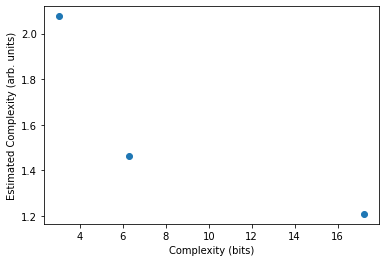

In [8]:
plt.scatter(np.array(information_complexities), np.array(experiment_complexities))
plt.xlabel('Complexity (bits)')
plt.ylabel('Estimated Complexity (arb. units)')
